# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, we'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice we would train this classifier, then export it for use in our application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
# [START Configuration settings for matplotlib]

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# [END Configuration settings for matplotlib]

In [2]:
# [Start Necessary Python Imports]
import time
import numpy as np
# [End]

# [START Importing Matplot lib for plotting]
import matplotlib.pyplot as plt
# [END]

# [START Importing torch essentials]
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets, models, transforms
# [END]

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/master/torchvision/transforms.html#)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. This converts the values of each color channel to be between -1 and 1 instead of 0 and 1.

In [3]:
train_dir = "train"
valid_dir = "valid"
test_dir = "test"

In [5]:
# [ START Transforms for the training, validation, and testing sets]
data_transforms = {
    "train" : transforms.Compose([
        transforms.RandomRotation(45),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
}
# [END]

# [START Load the datasets with ImageFolder]
dirs = {
    "train" : train_dir,
    "valid" : valid_dir, 
    "test" : test_dir
}

image_datasets = {_ : datasets.ImageFolder(dirs[_], transform=data_transforms[_])
                  for _ in ['train', 'valid', 'test']}
# [END]

# [START Using the image datasets and the trainforms to define the dataloaders]
dataloaders = dataloaders = {_: torch.utils.data.DataLoader(image_datasets[_], batch_size=32, shuffle=True)
               for _ in ['train', 'valid', 'test']}
# [END]

### Label mapping

You'll also need to load in a mapping from label to category name. You can find this in the file `label_map.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer coded labels to the actual names of the flowers.

In [7]:
import json

with open('label_map.json', 'r') as f:
    label_map = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to the rubric (TODO: Link to Rubric) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [10]:
# [START Defining the top classifier layer for the model]
class FFClassifier(nn.Module):
    
    def __init__(self, in_features, hidden_features, out_features, drop_prob=0.5):
        super().__init__()
        
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.fc2 = nn.Linear(hidden_features, hidden_features)
        self.fc3 = nn.Linear(hidden_features, out_features)
        
        self.drop = nn.Dropout(p=drop_prob)
        
    def forward(self, x):
        x = self.drop(F.relu(self.fc1(x)))
        x = self.drop(F.relu(self.fc2(x)))
        x = self.fc3(x)
        
        x = F.log_softmax(x, dim=1)
        return x
# [END]

In [11]:
# [START Defining the pretrained model to use]
model = models.vgg16(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
# [END]

In [12]:
model

VGG(
  (features): Sequential(
    (0): Conv2d (3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (5): Conv2d (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d (128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (10): Conv2d (128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (17): Conv2d (256, 512, kernel_size=(3, 3), 

In [16]:
# [START Initializing new classifier object]
classifier_custom = FFClassifier(25088, 4096, len(label_map))
# [END]

In [17]:
# [START Putting the new classifier on top of the pretrained model]
model.classifier = classifier_custom
# [END]

In [19]:
# [START defining the loss function and optimizer to use]
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
# [END]

In [20]:
# [START Defining a validation function for the model]
def validation(model, val_data, criterion, cuda=False):
    val_start = time.time()
    running_val_loss = 0
    accuracy = 0
    for inputs, labels in val_data:
        inputs, labels = Variable(inputs), Variable(labels)
        
        if cuda:
            inputs, labels = inputs.cuda(), labels.cuda()

        outputs = model.forward(inputs)
        val_loss = criterion(outputs, labels)

        ps = torch.exp(outputs.data)
        
        _, predicted = ps.max(dim=1)
        
        equals = predicted == labels.data
        accuracy += torch.sum(equals)/len(equals)

        running_val_loss += val_loss.data[0]
    val_time = time.time() - val_start
    print("Valid loss: {:.3f}".format(running_val_loss/len(dataloaders['valid'])),
          "Accuracy: {:.3f}".format(accuracy/len(dataloaders['valid'])),
          "Val time: {:.3f} s/batch".format(val_time/len(dataloaders['valid'])))
# [END]

In [21]:
torch.cuda.is_available()

True

## Begining the training process

In [28]:
# [START Setting parameters]
epochs = 10
cuda_availability = torch.cuda.is_available()
print(cuda_availability)
print_every_n = 20
# [END]

True


In [23]:
# [START Checking if cuda is available]
if cuda_availability:
    model.cuda()
else:
    model.cpu()
# [END]

In [24]:
# [START Setting the module into training mode(for dropout)]
model.train()
# [END]

VGG(
  (features): Sequential(
    (0): Conv2d (3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (5): Conv2d (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d (128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (10): Conv2d (128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (17): Conv2d (256, 512, kernel_size=(3, 3), 

In [29]:
for e in range(epochs):
    print(f"Epoch {e+1}/{epochs}")
    counter = 0
    running_loss = 0
    for inputs, labels in dataloaders['train']:
        counter += 1
        
        # Training pass
        inputs, labels = Variable(inputs), Variable(labels)
        
        
        
        optimizer.zero_grad()

        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.data[0]
        
        if counter % print_every_n == 0:
            print(f"Step: {counter}")
            print(f"Training loss {running_loss/counter:.3f}")
            model.eval()
            validation(model, dataloaders['valid'], criterion, cuda=cuda_availability)
            model.train()
    else:
        # Validation pass
        train_end = time.time()
        model.eval()
        validation(model, dataloaders['valid'], criterion, cuda=cuda_availability)

Epoch 1/10
Step: 20
Training loss 3.075
Valid loss: 2.462 Accuracy: 0.432 Val time: 0.609 s/batch
Step: 40
Training loss 3.139
Valid loss: 2.244 Accuracy: 0.454 Val time: 0.625 s/batch
Step: 60
Training loss 3.149
Valid loss: 2.301 Accuracy: 0.406 Val time: 0.612 s/batch
Step: 80
Training loss 3.179
Valid loss: 2.231 Accuracy: 0.438 Val time: 0.605 s/batch
Step: 100
Training loss 3.182
Valid loss: 1.990 Accuracy: 0.500 Val time: 0.606 s/batch
Step: 120
Training loss 3.188
Valid loss: 2.092 Accuracy: 0.484 Val time: 0.611 s/batch
Step: 140
Training loss 3.152
Valid loss: 1.791 Accuracy: 0.529 Val time: 0.608 s/batch
Step: 160
Training loss 3.157
Valid loss: 1.757 Accuracy: 0.556 Val time: 0.611 s/batch
Step: 180
Training loss 3.154
Valid loss: 1.889 Accuracy: 0.543 Val time: 0.616 s/batch
Step: 200
Training loss 3.153
Valid loss: 1.927 Accuracy: 0.521 Val time: 0.623 s/batch
Valid loss: 1.791 Accuracy: 0.536 Val time: 0.614 s/batch
Epoch 2/10
Step: 20
Training loss 2.058
Valid loss: 1.4

Valid loss: 1.325 Accuracy: 0.724 Val time: 0.625 s/batch
Step: 180
Training loss 2.526
Valid loss: 1.314 Accuracy: 0.724 Val time: 0.645 s/batch
Step: 200
Training loss 2.515
Valid loss: 1.281 Accuracy: 0.726 Val time: 0.630 s/batch
Valid loss: 1.258 Accuracy: 0.733 Val time: 0.644 s/batch
Epoch 10/10
Step: 20
Training loss 1.347
Valid loss: 0.963 Accuracy: 0.757 Val time: 0.627 s/batch
Step: 40
Training loss 2.150
Valid loss: 1.267 Accuracy: 0.722 Val time: 0.626 s/batch
Step: 60
Training loss 2.362
Valid loss: 1.326 Accuracy: 0.716 Val time: 0.627 s/batch
Step: 80
Training loss 2.451
Valid loss: 1.455 Accuracy: 0.726 Val time: 0.624 s/batch
Step: 100
Training loss 2.483
Valid loss: 1.402 Accuracy: 0.711 Val time: 0.623 s/batch
Step: 120
Training loss 2.493
Valid loss: 1.153 Accuracy: 0.749 Val time: 0.625 s/batch
Step: 140
Training loss 2.511
Valid loss: 1.285 Accuracy: 0.744 Val time: 0.620 s/batch
Step: 160
Training loss 2.506
Valid loss: 1.154 Accuracy: 0.761 Val time: 0.627 s/ba

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [30]:
# [START Validating model on the test set.]
model.cuda()
model.eval()
validation(model, dataloaders['test'], criterion, cuda=True)
# [END]

Valid loss: 1.407 Accuracy: 0.705 Val time: 0.682 s/batch


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [31]:
# [START Saving checkpoint]
model.class_to_idx = image_datasets['train'].class_to_idx
model.cpu()
torch.save({'arch': 'vgg16',
            'hidden': 4096,
            'state_dict': model.state_dict(),
            'class_to_idx': model.class_to_idx}, 
            'classifier.pt')
# [END]

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [32]:
# [START Write a function that loads a checkpoint and rebuilds the model]
def load_checkpoint(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    
    if checkpoint['arch'] == 'vgg16':
        model = models.vgg16(pretrained=True)
        for param in model.parameters():
            param.requires_grad = False
    
    model.class_to_idx = checkpoint['class_to_idx']
    
    # Create the classifier
    net = FFClassifier(25088, checkpoint['hidden'], len(model.class_to_idx))

    # Put the classifier on the pretrained network
    model.classifier = net
    
    model.load_state_dict(checkpoint['state_dict'])
    
    return model
# [END]

In [ ]:
# [START loading model from checkpoint]
model = load_checkpoint('classifier.pt')

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [33]:
from PIL import Image

In [34]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # Resize and crop out the center 224x224 square
    aspect = image.size[0]/image.size[1]
    if aspect > 0:
        image.thumbnail((10000, 256))
    else:
        image.thumbnail((256, 10000))
    left_margin = (image.width-224)/2
    top_margin = (image.height-224)/2
    image = image.crop((left_margin, top_margin, left_margin+224, top_margin+224))
    
    # normalizing
    image = np.array(image)/255
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = (image - mean)/std
    
    # Color channels in first dimension as per expectation
    image = image.transpose((2, 0, 1))
    
    return image

In [37]:
image_path = 'test/28/image_05230.jpg'
image = Image.open(image_path)
image = process_image(image)

## Class Prediction

Once you can get images in the correct format 

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictio

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [38]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    image_in = Image.open(image_path)
    image_in = process_image(image_in)
    
    image_tensor = torch.from_numpy(image_in).type(torch.FloatTensor)
    inputs = Variable(image_tensor, requires_grad=False)
    inputs = inputs.unsqueeze(0)
    
    ps = torch.exp(model.forward(inputs))
    
    top_probs, top_labels = ps.topk(topk)
    top_probs, top_labels = top_probs.data.numpy().squeeze(), top_labels.data.numpy().squeeze()
    
    idx_to_class = {val: key for key, val in model.class_to_idx.items()}
    top_classes = [idx_to_class[each] for each in top_labels]
    
    return top_probs, top_classes

In [39]:
image_path = 'test/28/image_05230.jpg'
model.eval()
model.cpu()
predict(image_path, model)

(array([ 0.0571664 ,  0.054674  ,  0.05163857,  0.04158187,  0.04084549], dtype=float32),
 ['9', '28', '3', '94', '82'])

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `label_map.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined below.

In [40]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

In [ ]:
# TODO: Display an image along with the top 5 classes

In [42]:
images, labels = next(iter(dataloaders['test']))

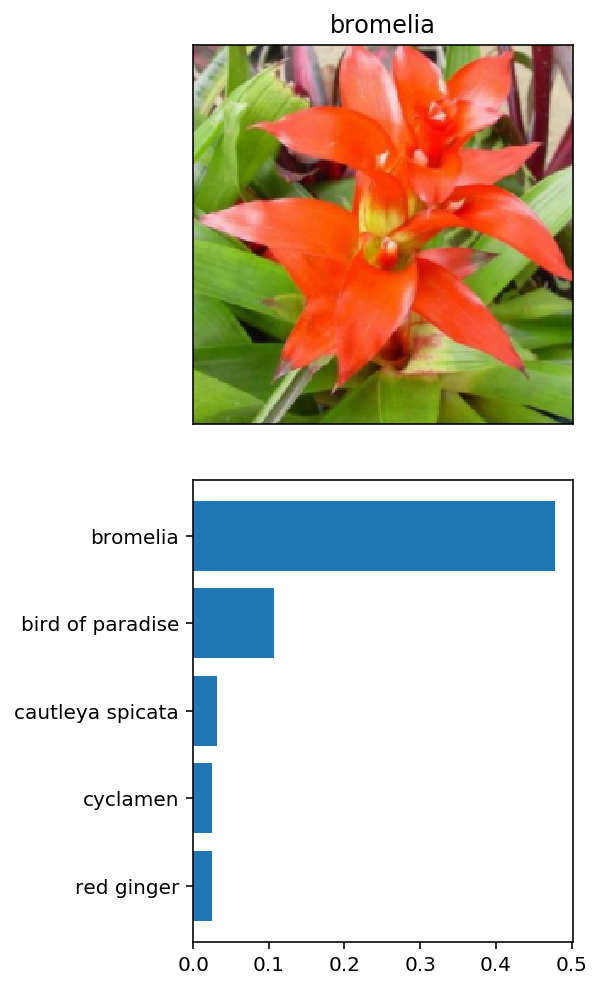

In [45]:
img_idx = 25

inputs = Variable(images[img_idx,:].unsqueeze(0))
model.eval()
model.cpu()
ps = torch.exp(model.forward(inputs))

top_probs, top_classes = ps.topk(5)
idx_to_class = {val: key for key, val in model.class_to_idx.items()}
top_classes = [idx_to_class[each] for each in top_classes.data.squeeze()]

fig, (img_ax, p_ax) = plt.subplots(figsize=(4,7), nrows=2)
img_ax = imshow(inputs.data.squeeze(), ax=img_ax)
img_ax.set_title(label_map[idx_to_class[labels[img_idx]]])
img_ax.xaxis.set_visible(False)
img_ax.yaxis.set_visible(False)

p_ax.barh(np.arange(5, 0, -1), top_probs.data.numpy().squeeze())
top_cat_names = [label_map[each] for each in top_classes]
p_ax.set_yticks(range(1,6))
p_ax.set_yticklabels(reversed(top_cat_names));
fig.tight_layout(pad=0.1, h_pad=0)